In [ ]:
!git clone --recurse-submodules https://github.com/JandJane/DialogueActClassification.git

In [ ]:
!unzip DialogueActClassification/swda/swda.zip -d DialogueActClassification/swda/swda

In [ ]:
!pip install -r DialogueActClassification/requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
from tqdm import tqdm

import sys
sys.path.append('DialogueActClassification')

from dialogue_classification.config import MAX_UTTERANCE_LEN
from dialogue_classification.dataset_utils import load_swda_corpus_data
from dialogue_classification.training import train_model


In [3]:
talks, talk_names, tag_indices, tag_occurances = load_swda_corpus_data('DialogueActClassification/swda/swda/swda')

Loading SwDA Corpus...

Found 43 different utterance tags.

Loaded SwDA Corpus.


In [4]:
len(talks), len(talk_names)

(1155, 1155)

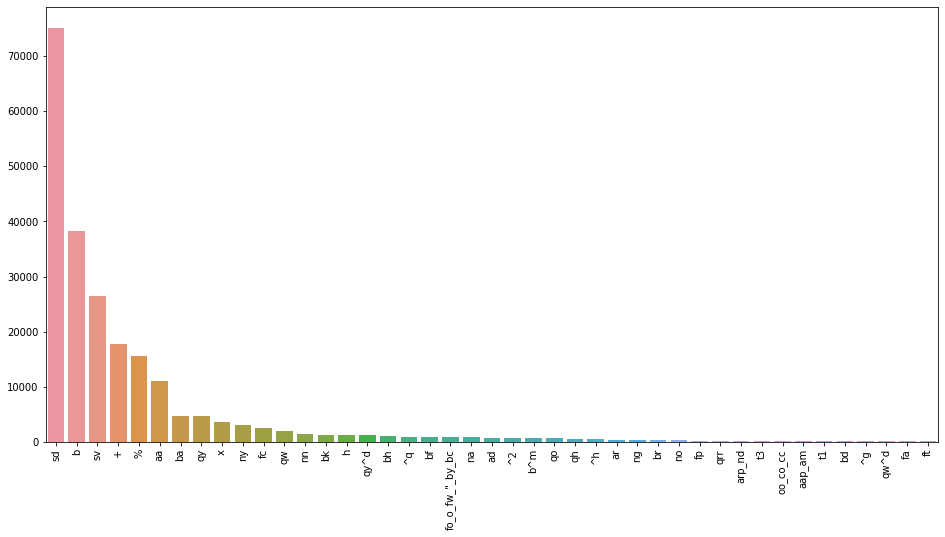

In [5]:
tag_occurances = pd.Series(tag_occurances)
tag_occurances = tag_occurances.sort_values(ascending=False)

plt.figure(figsize=(16, 8))
sns.barplot(x=tag_occurances.index, y=tag_occurances.values)
plt.xticks(rotation=90)
plt.show()

In [6]:
texts, labels = [], []
for text, label in talks:
    assert len(text) == len(label)
    text = [' '.join(utterance) for utterance in text]
    texts.append(text)
    labels.append(label)

In [7]:
dialogue_lens = pd.Series([len(dialogue) for dialogue in texts])
dialogue_lens.describe()

count    1155.000000
mean      191.875325
std        79.728384
min        38.000000
25%       131.000000
50%       173.000000
75%       240.000000
max       540.000000
dtype: float64

In [8]:
utterance_lens = [len(utterance.split()) for utterance in sum(texts, [])]
utterance_lens = pd.Series(utterance_lens)
utterance_lens.describe()

count    221616.000000
mean          7.057018
std           6.901779
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max          79.000000
dtype: float64

In [9]:
utterance_lens.quantile(0.95)  # => MAX_UTTERANCE_LEN = 25

21.0

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, model_max_length=MAX_UTTERANCE_LEN)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
input_ids, attention_masks = [], []
for text in tqdm(texts):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    input_ids.append(encoded_input['input_ids'])
    attention_masks.append(encoded_input['attention_mask'])    

100%|██████████| 1155/1155 [01:02<00:00, 18.51it/s]


In [12]:
for i in range(len(input_ids)):
    if input_ids[i].size(1) < MAX_UTTERANCE_LEN:
        padding_shape = (input_ids[i].size(0), MAX_UTTERANCE_LEN - input_ids[i].size(1))
        input_ids[i] = torch.cat((input_ids[i], torch.zeros(padding_shape)), axis=1)
        attention_masks[i] = torch.cat((attention_masks[i], torch.zeros(padding_shape)), axis=1)

In [13]:
dialogue_lengths = [len(dialogue) for dialogue in input_ids]
dialogue_lengths = torch.LongTensor(dialogue_lengths)

input_ids = pad_sequence(input_ids, batch_first=True)
attention_masks = pad_sequence(attention_masks, batch_first=True)

labels = [torch.LongTensor(label) for label in labels]
y = pad_sequence(labels, batch_first=True)

In [14]:
dialogue_lengths.shape, input_ids.shape, attention_masks.shape, y.shape

(torch.Size([1155]),
 torch.Size([1155, 540, 25]),
 torch.Size([1155, 540, 25]),
 torch.Size([1155, 540]))

In [15]:
data = [input_ids, attention_masks, dialogue_lengths, y]

In [16]:
talk_names = np.array(talk_names)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change th

[EPOCH 0] Train loss: 3.372353920423652
[EPOCH 0] Val loss: 3.2361598355429515, Accuracy: 0.6073795627658523
[EPOCH 0] Test loss: 3.252112340927124, Accuracy: 0.5939299955693398
[EPOCH 1] Train loss: 3.2185949680814705
[EPOCH 1] Val loss: 3.208194851875305, Accuracy: 0.6250865565337818
[EPOCH 1] Test loss: 3.221968173980713, Accuracy: 0.6156402303943288
[EPOCH 2] Train loss: 3.1986130281273586
[EPOCH 2] Val loss: 3.198983601161412, Accuracy: 0.6474923335641507
[EPOCH 2] Test loss: 3.2090405941009523, Accuracy: 0.6373504652193177
[EPOCH 3] Train loss: 3.1879340035031993
[EPOCH 3] Val loss: 3.1956353272710527, Accuracy: 0.6477890988228311
[EPOCH 3] Test loss: 3.208317518234253, Accuracy: 0.642002658396101
[EPOCH 4] Train loss: 3.188262741879163
[EPOCH 4] Val loss: 3.191815572125571, Accuracy: 0.6538233257493323
[EPOCH 4] Test loss: 3.2037477493286133, Accuracy: 0.6477625166149756
[EPOCH 5] Train loss: 3.1844885159298717
[EPOCH 5] Val loss: 3.1904853752681186, Accuracy: 0.6582253437530913

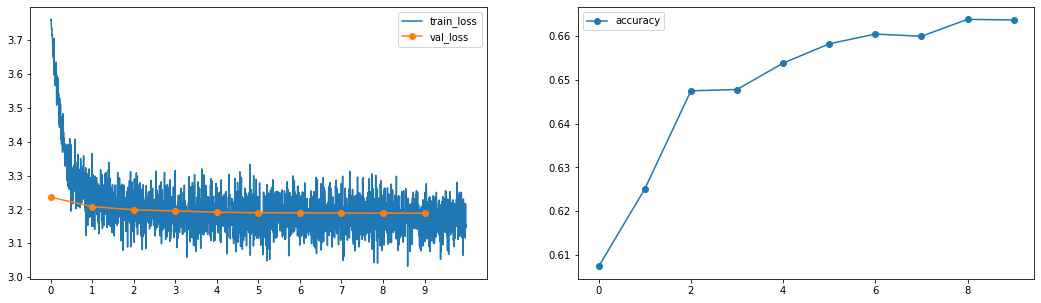

In [17]:
net_conf = {
    'input_size': 768,
    'output_size': len(tag_occurances),
    'rnn_hidden_size': 128,
    'bert_layers_to_finetune': 2,
    'use_attention': False,
}

score = train_model(data, talk_names, net_conf=net_conf, batch_size=4, bert_finetuning_epochs=3, lr_bert=0.0002, lr_head=0.001,
                    verbose=True, plot=True)